In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import shutil

#Create Kaggle config directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Copy the kaggle.json file
shutil.copy("/content/drive/MyDrive/SkinCancerEnvironment/.kaggle/kaggle.json", "/root/.kaggle/")

# Set permissions
os.chmod("/root/.kaggle/kaggle.json", 600)


In [5]:
!pip install -q kaggle

# Download the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [00:54<00:00, 254MB/s]
100% 5.20G/5.20G [00:55<00:00, 101MB/s]


In [6]:
import zipfile

with zipfile.ZipFile("skin-cancer-mnist-ham10000.zip", "r") as zip_ref:
    zip_ref.extractall("HAM10000")


In [7]:
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [8]:
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load metadata
metadata_path = "HAM10000/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)

# Attach correct image paths
def get_image_path(image_id):
    path1 = f"HAM10000/HAM10000_images_part_1/{image_id}.jpg"
    path2 = f"HAM10000/HAM10000_images_part_2/{image_id}.jpg"
    return path1 if os.path.exists(path1) else path2

df['path'] = df['image_id'].map(get_image_path)

# Remove any invalid images
def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except:
        return False

df = df[df['path'].apply(is_valid_image)].reset_index(drop=True)

# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [10]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
# Match class weights to generator's class indices
class_labels = train_df['dx'].unique()
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_df['dx'])
label_to_index = train_generator.class_indices
index_to_weight = {label_to_index[label]: weight for label, weight in zip(class_labels, class_weights)}

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    class_weight=index_to_weight,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 278ms/step - accuracy: 0.1882 - loss: 1.9695 - val_accuracy: 0.0514 - val_loss: 1.9428
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.1250 - loss: 2.3905 - val_accuracy: 0.0514 - val_loss: 1.9469
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 276ms/step - accuracy: 0.0812 - loss: 1.9856 - val_accuracy: 0.0514 - val_loss: 1.8956
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.1875 - loss: 2.2709 - val_accuracy: 0.0514 - val_loss: 1.8978


In [14]:
# Print final epoch's training and validation accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Final Training Accuracy: 0.1875
Final Validation Accuracy: 0.0514


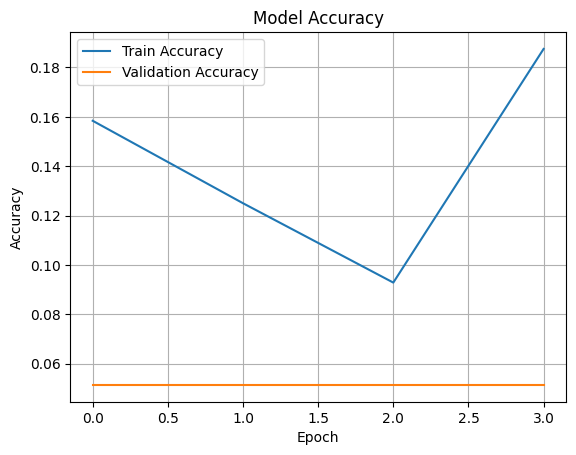

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
